# Stock Analysis and Optimization with Generative AI

# Setup

In [1]:
# Install necessary libraries
!pip install langchain-openai yfinance PyPortfolioOpt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 9.4 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for ecos: filename=ecos-2.0.14-cp312-cp312-macosx_10_9_universal2.whl size=142676 sha256=ce26535169c7cb70a7873000ffdd574aefc895d1e4f2c9fd7f3f9675a9c4c8e0
  Stored in directory: /Users/matiashadjadj/Library/Caches/pip/wheels/b8/d9/1e/77a592ed2465d4dde07f30f787f9d43834c0fd7a1467371694
Successfully built ecos


In [ ]:
#API KEY
api_key = "your_api_key"

In [ ]:
## Libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import yfinance as yf
from langchain_openai import ChatOpenAI
from scipy.optimize import minimize
from pypfopt import risk_models, expected_returns, BlackLittermanModel, EfficientFrontier, black_litterman

In [ ]:
# Function to initialize OpenAI LLM model
def initialize_llm(api_key):
    """
    Initialize the ChatOpenAI language model.

    Parameters:
    api_key (str): The API key for accessing the OpenAI service.

    Returns:
    ChatOpenAI: The initialized language model.
    """
    llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=api_key)
    return llm


In [ ]:
# Function to calculate start and end dates based on the number of years from today
def calculate_date_range(years):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=years * 365)
    return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')


In [ ]:
# Function to invoke LLM response based on given prompt
def get_llm_response(llm, prompt):
    """
    Get the response from the language model for a given prompt.

    Parameters:
    llm (ChatOpenAI): The initialized language model.
    prompt (str): The prompt to send to the language model.

    Returns:
    str: The content of the language model's response.
    """
    response = llm(prompt)
    return display(Markdown(response.content))


In [ ]:
# Plots the RSI for a given stock and highlights overbought and oversold thresholds.
def plot_rsi(data, ticker):
    """
    Plot the Relative Strength Index (RSI) for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    # Define the lookback window for RSI calculation
    window = 14

    # Calculate the RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    # Plot the RSI
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, rsi, label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--')        # Add a horizontal line at RSI = 70 (overbought threshold)
    plt.axhline(30, color='green', linestyle='--')      # Add a horizontal line at RSI = 30 (oversold threshold)

    # Add title, labels, and legend
    plt.title(f'RSI of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()


In [ ]:
# Plot Bollinger Bands, including the closing price, middle band (SMA), and upper/lower bands (±2 standard deviations).
def plot_bollinger_bands(data, ticker):
    """
    Plot the Bollinger Bands for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    # Define the rolling window period for Bollinger Bands
    window = 20

    # Calculate the middle band (simple moving average) and outer bands (±2 standard deviations)
    data['Middle Band'] = data['Close'].rolling(window=window).mean()
    data['Upper Band'] = data['Middle Band'] + 2 * data['Close'].rolling(window=window).std()  # Upper band
    data['Lower Band'] = data['Middle Band'] - 2 * data['Close'].rolling(window=window).std()  # Lower band

    # Plot the closing price and Bollinger Bands
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['Close'], label='Closing Price')  # Plot closing price
    plt.plot(data.index, data['Middle Band'], label='Middle Band', color='blue')  # Plot middle band
    plt.plot(data.index, data['Upper Band'], label='Upper Band', color='red')  # Plot upper band
    plt.plot(data.index, data['Lower Band'], label='Lower Band', color='green')  # Plot lower band

    # Add title, labels, and legend
    plt.title(f'Bollinger Bands of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [ ]:
# Plots the Price-to-Earnings (P/E) ratios over time for a list of stocks, using their historical closing prices and trailing EPS.
def plot_pe_ratios(data, ticker, eps):
    """
    Plot the Price-to-Earnings (P/E) ratio for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.
    eps (float): The earnings per share of the stock.

    Returns:
    None
    """
    # Check if EPS value is valid
    if eps is None or eps == 0:
        print(f"Warning: EPS for {ticker} is not available or zero. PE ratio can't be calculated.")
        return

    # Calculate the P/E ratio
    pe_ratio = data['Close'] / eps

    # Create and customize the plot
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, pe_ratio, label=f'{ticker} PE Ratio')
    plt.title('PE Ratios of Selected Stocks')
    plt.xlabel('Date')
    plt.ylabel('PE Ratio')
    plt.legend()
    plt.show()


In [ ]:
# Plots a bar chart comparing beta values of the given stock tickers.
def plot_beta_comparison(tickers, start_date, end_date):
    betas = {}

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        try:
            # Retrieve historical data
            data = stock.history(start=start_date, end=end_date)
            # Get the beta value from stock's info
            beta = stock.info.get('beta')

            # Skip to the next ticker if beta is not available
            if beta is None:
                print(f"Warning: Beta for {ticker} is not available.")
                continue

            betas[ticker] = beta # Store the beta value

        # Handle errors related to missing data
        except KeyError as e:
            print(f"Error retrieving data for {ticker}: {e}")
        # Handle other unexpected errors
        except Exception as e:
            print(f"An error occurred with ticker {ticker}: {e}")

    # Plotting the bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(betas.keys(), betas.values(), color='blue')
    plt.title('Beta Comparison of Selected Stocks')
    plt.xlabel('Ticker')
    plt.ylabel('Beta')
    plt.show()

In [ ]:
# Plots the MACD and signal line for each ticker to show momentum trends.
def plot_macd(data, ticker):
    """
    Plot the Moving Average Convergence Divergence (MACD) for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    # Calculate the 12-day and 26-day EMA
    ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['Close'].ewm(span=26, adjust=False).mean()

    # Calculate the MACD
    macd = ema_12 - ema_26

    # Calculate the signal line
    signal = macd.ewm(span=9, adjust=False).mean()

    # Plot MACD and signal line
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, macd, label=f'{ticker} MACD')
    plt.plot(data.index, signal, label=f'{ticker} Signal Line')
    plt.title(f'MACD and Signal Line of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()
    plt.show()


In [ ]:
# Calculates and returns key performance indicators (RSI, Bollinger Bands, P/E Ratio, Beta, and MACD) for a list of stock tickers over a specified date range.
def calculate_kpis(tickers, start_date, end_date):
    """
    Calculate KPIs for a list of stocks over a given time period.

    Parameters:
    tickers (list): A list of stock ticker symbols.
    start_date (str): The start date for the analysis.
    end_date (str): The end date for the analysis.

    Returns:
    dict: A dictionary containing the KPIs for each stock.
    """
    kpi_data = {}
    for ticker in tickers:
        # Download historical stock data
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        kpi_data[ticker] = {}

        # Calculate RSI
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()      # Average gains
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()     # Average losses
        rs = gain / loss                                                  # Relative strength
        rsi = 100 - (100 / (1 + rs))                                      # RSI formula
        kpi_data[ticker]['RSI'] = rsi

        # Calculate Bollinger Bands
        middle_band = data['Close'].rolling(window=20).mean()                     # Middle band (SMA)
        upper_band = middle_band + 2 * data['Close'].rolling(window=20).std()     # Upper band
        lower_band = middle_band - 2 * data['Close'].rolling(window=20).std()     # Lower band
        kpi_data[ticker]['Bollinger Bands'] = {
            'Middle Band': middle_band,
            'Upper Band': upper_band,
            'Lower Band': lower_band
        }

        # Calculate P/E Ratio
        try:
            eps = stock.info.get('trailingEps') # Get trailing EPS
            if eps and eps != 0:
                pe_ratio = data['Close'] / eps
                kpi_data[ticker]['P/E Ratio'] = pe_ratio # Calculate P/E ratio
            else:
                kpi_data[ticker]['P/E Ratio'] = None
        except Exception as e:
            kpi_data[ticker]['P/E Ratio'] = None
            print(f"An error occurred with ticker {ticker} P/E Ratio: {e}")

        # Calculate Beta
        try:
            beta = stock.info.get('beta') # Get beta value
            kpi_data[ticker]['Beta'] = beta
        except Exception as e:
            kpi_data[ticker]['Beta'] = None
            print(f"An error occurred with ticker {ticker} Beta: {e}")

        # Calculate MACD
        ema_12 = data['Close'].ewm(span=12, adjust=False).mean()    # 12-day EMA
        ema_26 = data['Close'].ewm(span=26, adjust=False).mean()    # 26-day EMA
        macd = ema_12 - ema_26    # MACD line
        signal = macd.ewm(span=9, adjust=False).mean()   # Signal line
        kpi_data[ticker]['MACD'] = {
            'MACD': macd,
            'Signal Line': signal
        }

    return kpi_data


# API KEY

In [ ]:
# The API key for accessing the OpenAI service
api_key = "your-api-key" # insert here your key

# Inputs

In [ ]:
# Intialize OpenAI LLM
llm = initialize_llm(api_key=api_key)

In [ ]:
# Define the number of years for the analysis
years = 2  # Example: 2 years

In [ ]:
# List of assets to analyze
assets = [
    "Apple (AAPL)",
    "Amazon (AMZN)",
    "Bitcoin (BTC-USD)",
    "Alphabet (GOOGL)",
    "Meta (META)",
    "Microsoft (MSFT)",
    "Nvidia (NVDA)",
    "S&P 500 index (SPY)",
    "Tesla (TSLA)"
]

In [ ]:
# Query to fetch and sort tickers alphabetically from a list of specified assets
query = f"""
fetch me the tickers from the following assets: {assets}
Your output must be sorted alhabetically by the ticker and it should be like this:
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']
"""

In [ ]:
# Feed prompt to LLM model, and invoke response
get_llm_response(llm = llm, prompt = query)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Sure, here are the tickers sorted alphabetically:

```python
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']
```

In [ ]:
# Convert asset names to their ticker symbols
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']

In [ ]:
# Calculate the start and end dates
start_date, end_date = calculate_date_range(years)

# Fetch historical stock data using yfinance
data = yf.download(tickers, start=start_date, end=end_date)

# Display the first few rows of the fetched data
data.head()


[*********************100%%**********************]  9 of 9 completed


Price        Adj Close                                                    \
Ticker            AAPL        AMZN       BTC-USD       GOOGL        META   
Date                                                                       
2022-08-09  163.301544  137.830002  23164.318359  116.496292  168.184387   
2022-08-10  167.579147  142.690002  23947.642578  119.562775  177.974274   
2022-08-11  166.836517  140.639999  23957.529297  118.703758  177.126022   
2022-08-12  170.411087  143.550003  24402.818359  121.540512  180.129852   
2022-08-13         NaN         NaN  24424.068359         NaN         NaN   

Price                                                           Close  ...  \
Ticker            MSFT       NVDA         SPY        TSLA        AAPL  ...   
Date                                                                   ...   
2022-08-09  277.427094  17.066780  399.157501  283.333344  164.919998  ...   
2022-08-10  284.168701  18.076643  407.541382  294.356659  169.240005  ...   
2022-08-11  282.065643  17.921816  407.541382  286.630005  168.490005  ...   
2022-08-12  286.871246  18.687952  414.440643  300.029999  172.100006  ...   
2022-08-13         NaN        NaN         NaN         NaN         NaN  ...   

Price             Open      Volume                                       \
Ticker            TSLA        AAPL        AMZN      BTC-USD       GOOGL   
Date                                                                      
2022-08-09  290.293335  63135500.0  40434700.0  23555719219  19086500.0   
2022-08-10  297.066681  70170500.0  54773800.0  32837431722  30930400.0   
2022-08-11  296.513336  57149200.0  44867300.0  37127036580  24293700.0   
2022-08-12  289.416656  68039400.0  47643500.0  27265804688  19096300.0   
2022-08-13         NaN         NaN         NaN  22987346289         NaN   

Price                                                                    
Ticker            META        MSFT         NVDA         SPY        TSLA  
Date                                                                     
2022-08-09  18655100.0  23405200.0  668263000.0  44931800.0  86244600.0  
2022-08-10  30262100.0  24687800.0  597422000.0  68665700.0  94918800.0  
2022-08-11  24079100.0  20065900.0  509327000.0  59489700.0  70155000.0  
2022-08-12  21274000.0  22619700.0  478094000.0  61694500.0  79657200.0  
2022-08-13         NaN         NaN          NaN         NaN         NaN  

[5 rows x 54 columns]

# Outputs

### RSI

**What is RSI:** The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. RSI values above 70 indicate that a stock may be overbought, while values below 30 suggest it may be oversold.

**How to Interpret:** High RSI values (>70) indicate overbought conditions, potentially signaling a sell opportunity. Low RSI values (<30) indicate oversold conditions, potentially signaling a buy opportunity.

[*********************100%%**********************]  1 of 1 completed


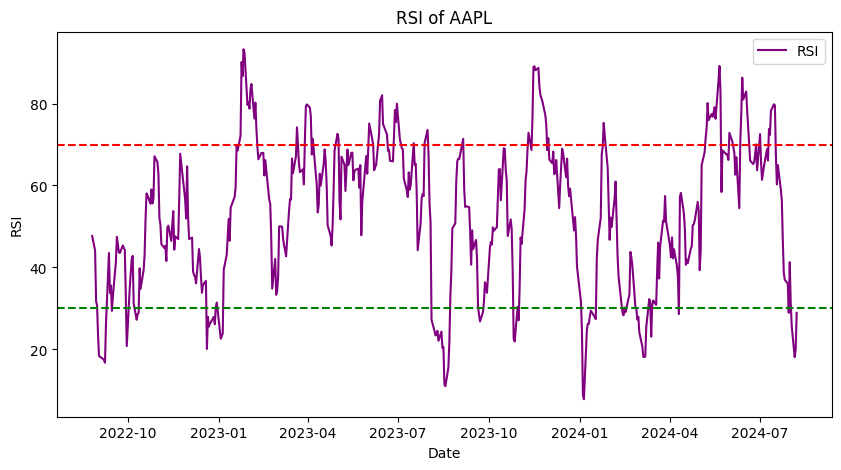

[*********************100%%**********************]  1 of 1 completed


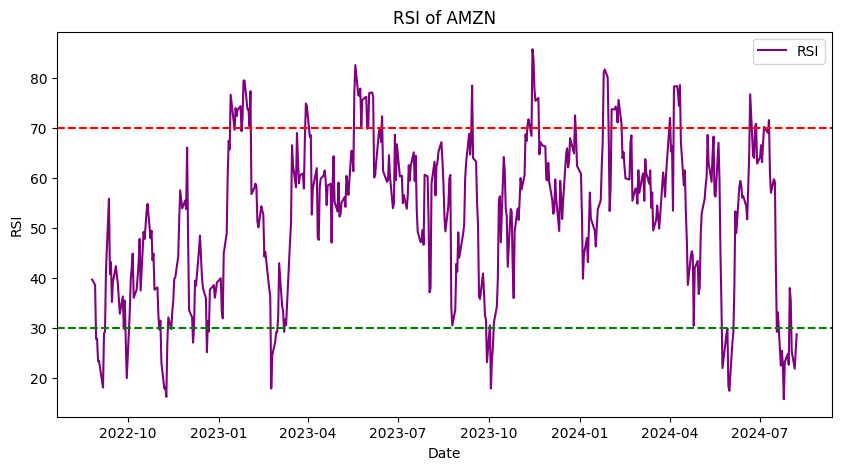

[*********************100%%**********************]  1 of 1 completed


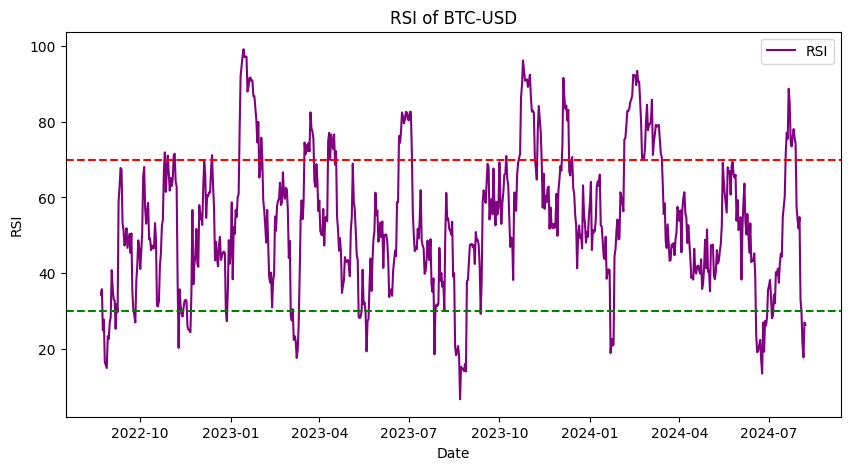

[*********************100%%**********************]  1 of 1 completed


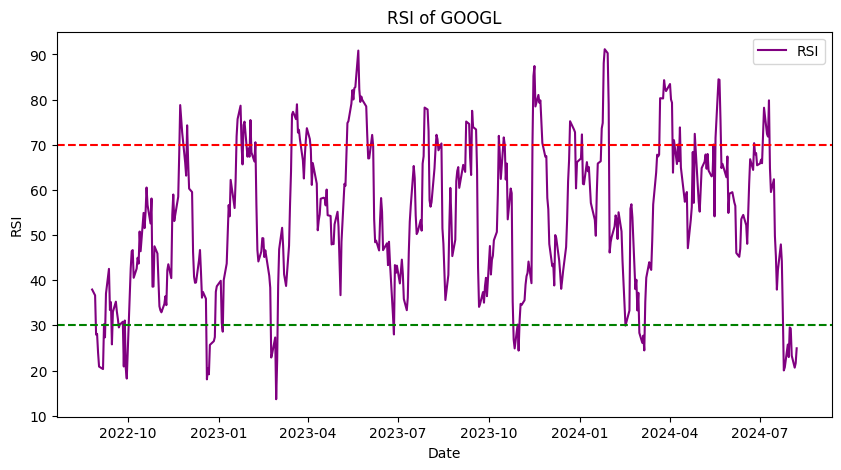

[*********************100%%**********************]  1 of 1 completed


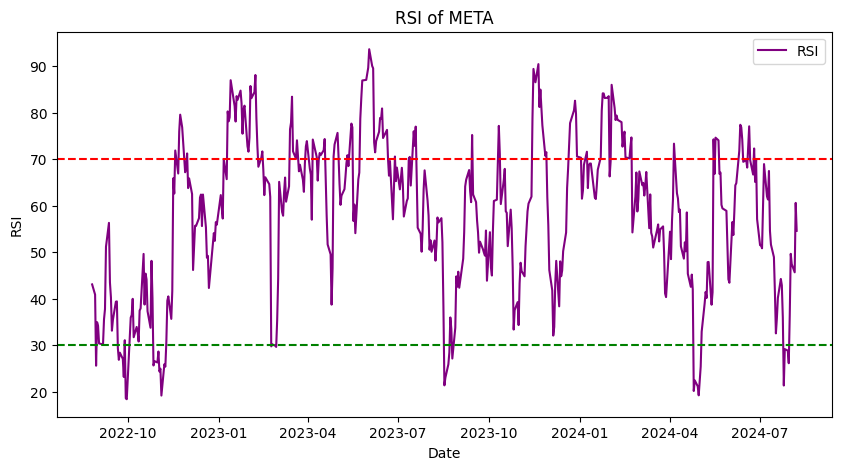

[*********************100%%**********************]  1 of 1 completed


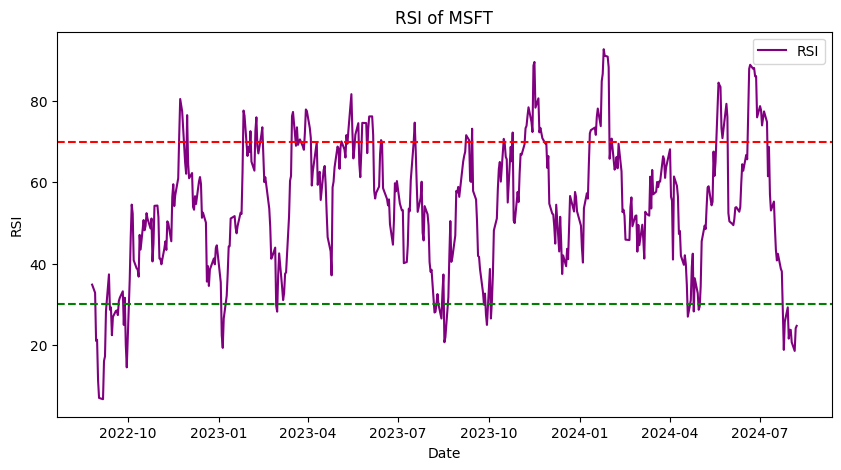

[*********************100%%**********************]  1 of 1 completed


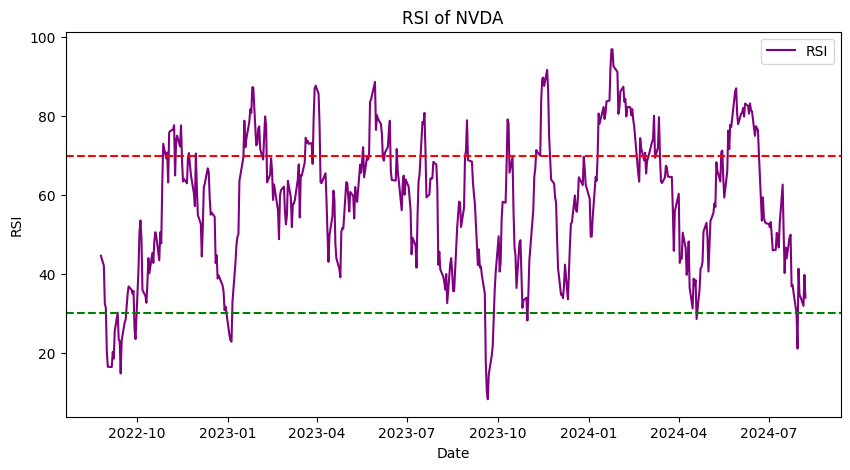

[*********************100%%**********************]  1 of 1 completed


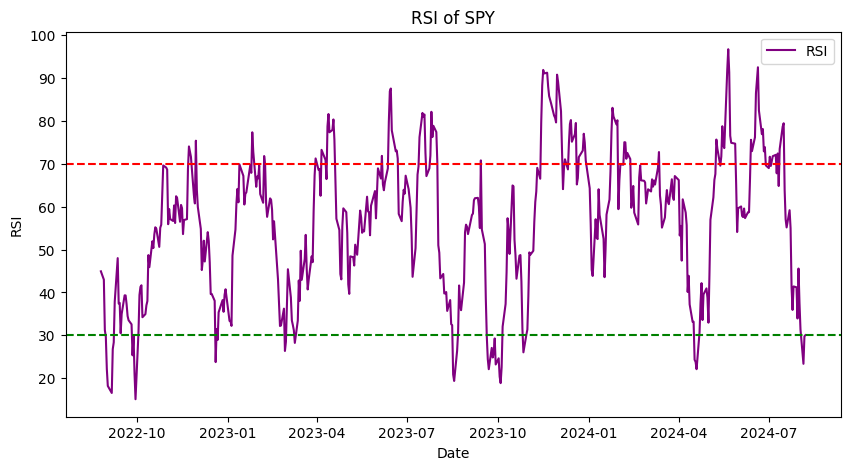

[*********************100%%**********************]  1 of 1 completed


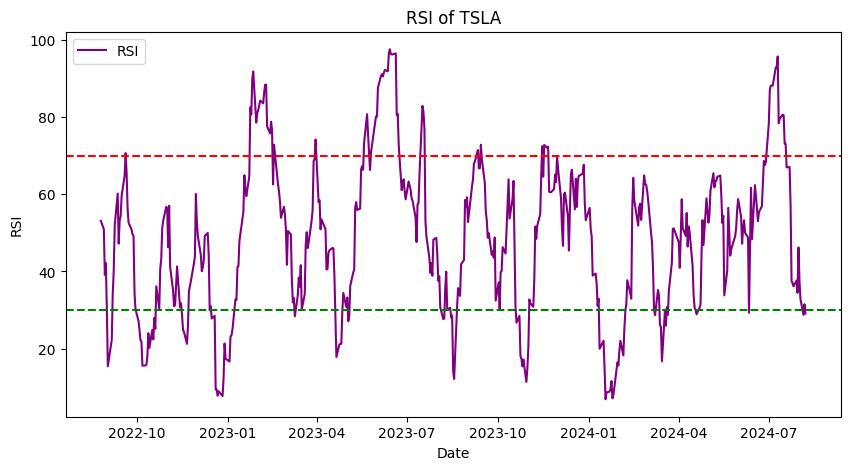

In [ ]:
# Download historical data for each ticker and plot its RSI
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_rsi(data_ticker, ticker)


### Bollinger Bands

**What are Bollinger Bands:** Bollinger Bands consist of a middle band (simple moving average) and two outer bands (standard deviations). They help identify overbought and oversold conditions.

**How to Interpret:** When the price touches the upper band, it may indicate that the stock is overbought. Conversely, touching the lower band may indicate that the stock is oversold.

[*********************100%%**********************]  1 of 1 completed


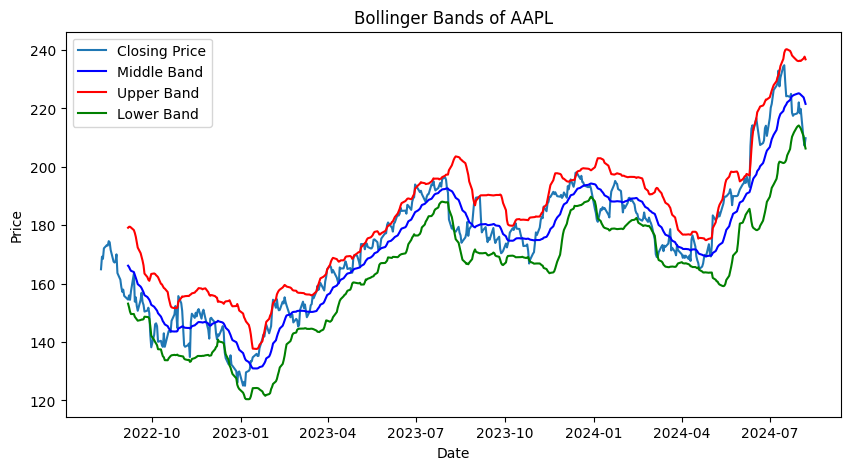

[*********************100%%**********************]  1 of 1 completed


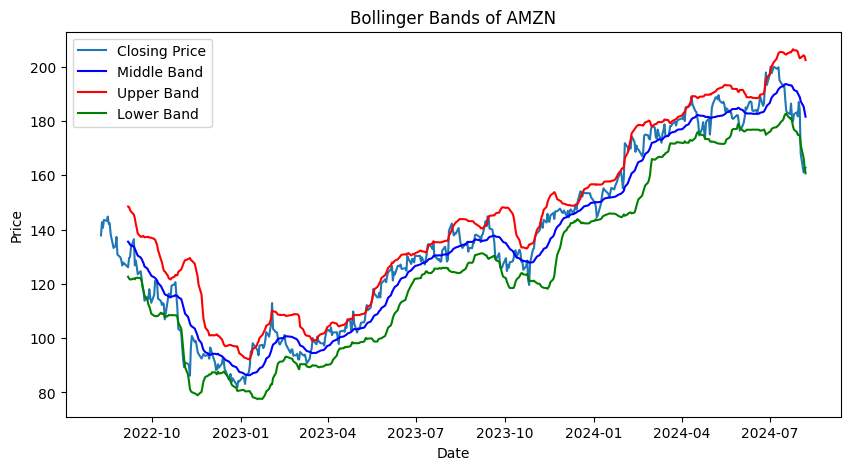

[*********************100%%**********************]  1 of 1 completed


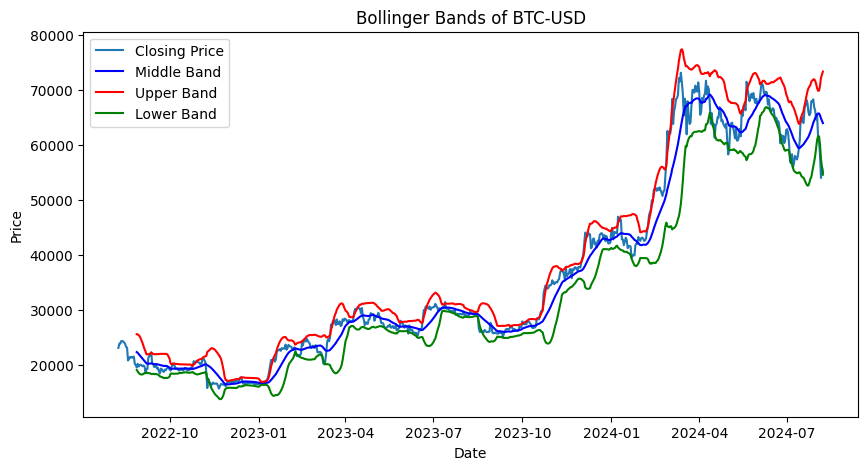

[*********************100%%**********************]  1 of 1 completed


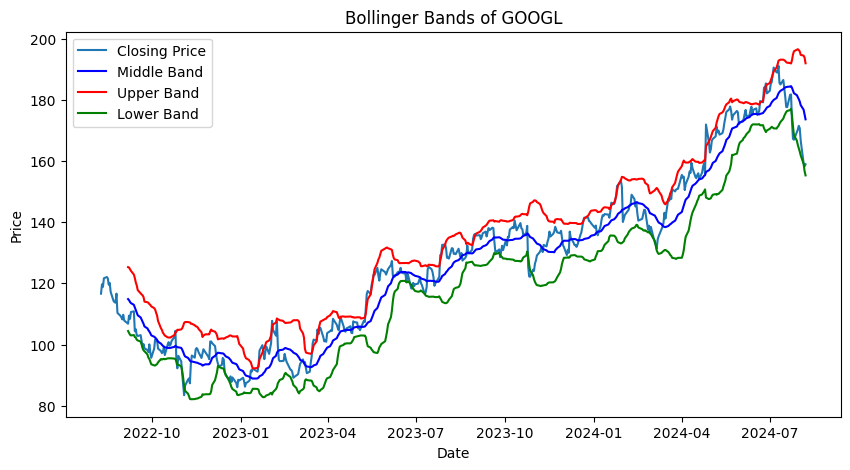

[*********************100%%**********************]  1 of 1 completed


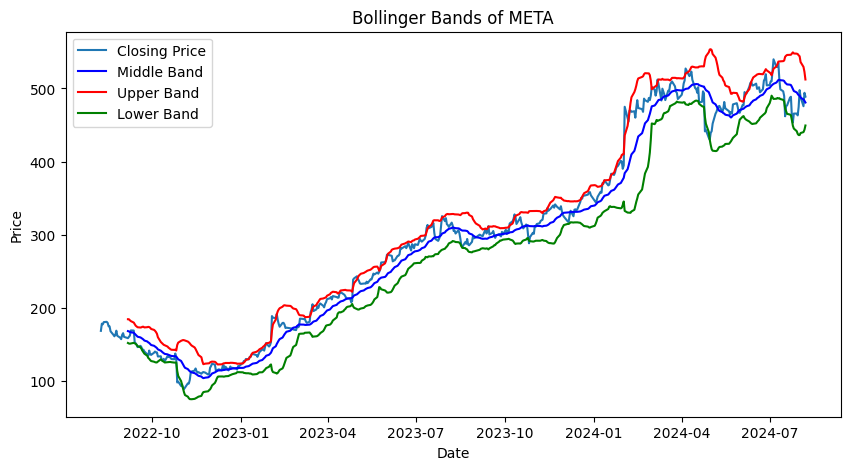

[*********************100%%**********************]  1 of 1 completed


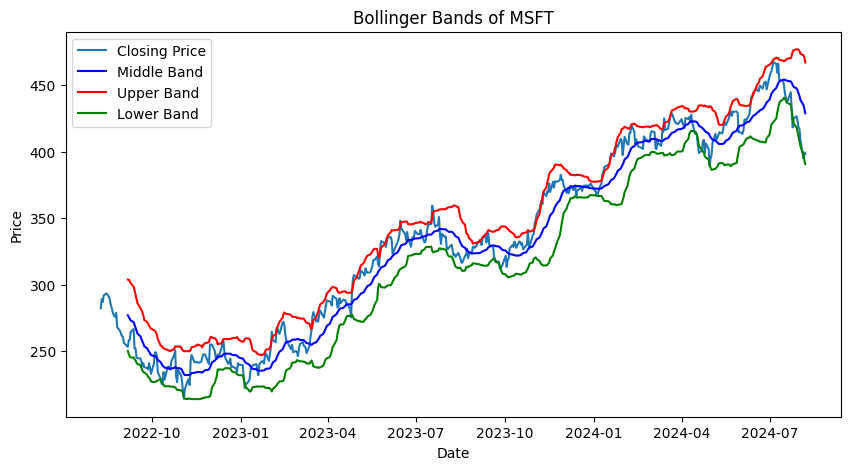

[*********************100%%**********************]  1 of 1 completed


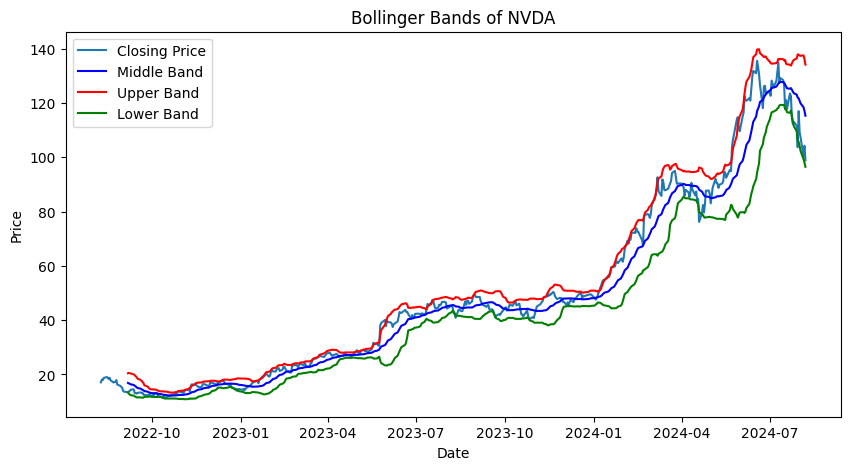

[*********************100%%**********************]  1 of 1 completed


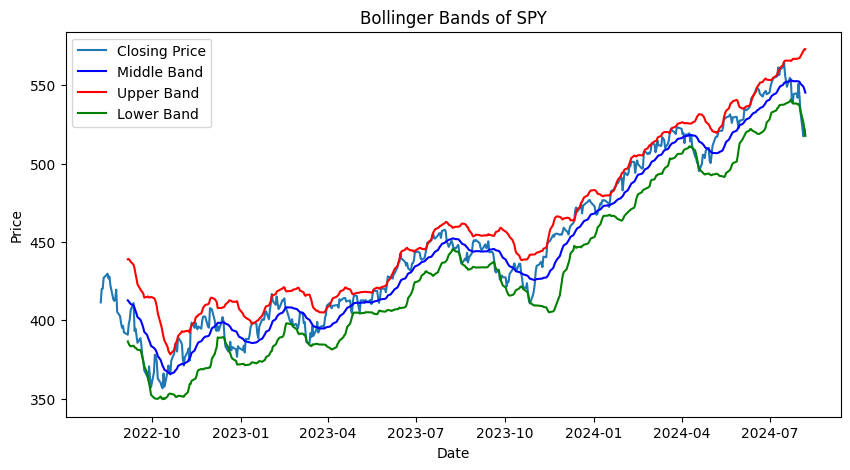

[*********************100%%**********************]  1 of 1 completed


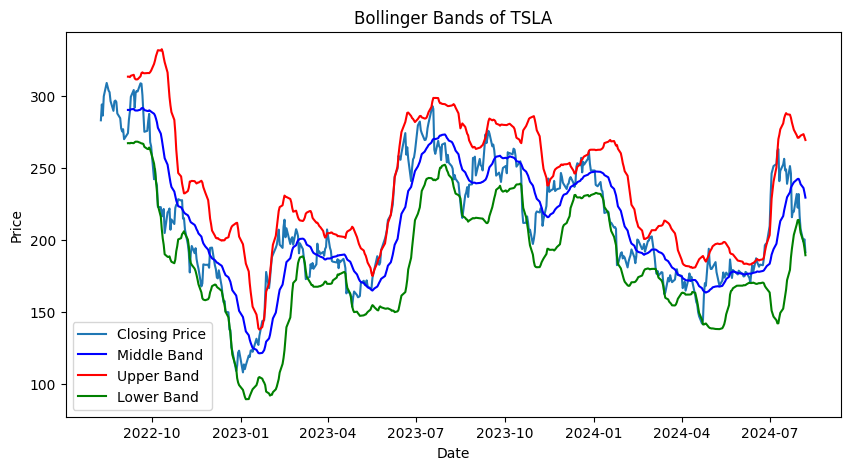

In [ ]:
# Download historical data for each ticker and plot its Bollinger Bands
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_bollinger_bands(data_ticker, ticker)


### Price-to-Earnings Ratio (P/E)



**What is P/E Ratio:** The Price-to-Earnings (P/E) ratio measures a company's current share price relative to its per-share earnings. It is used to gauge whether a stock is overvalued or undervalued.

**How to Interpret:** A high P/E ratio may indicate that a stock is overvalued or that investors are expecting high growth rates in the future. A low P/E ratio may indicate that the stock is undervalued.

[*********************100%%**********************]  1 of 1 completed


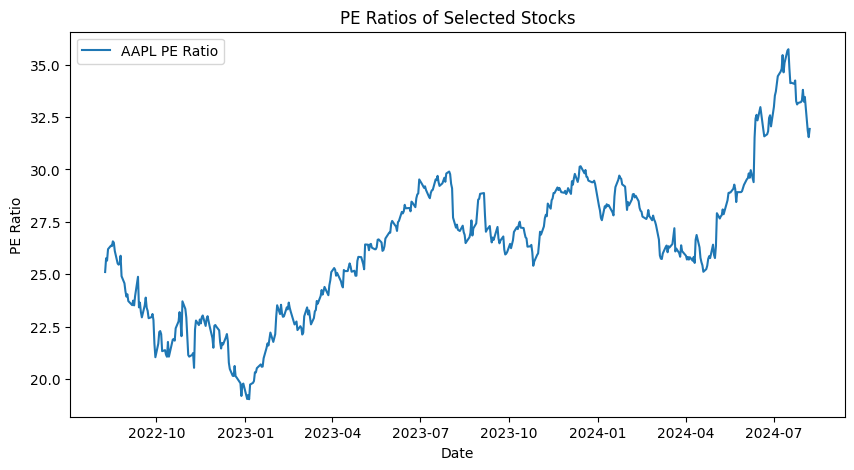

[*********************100%%**********************]  1 of 1 completed


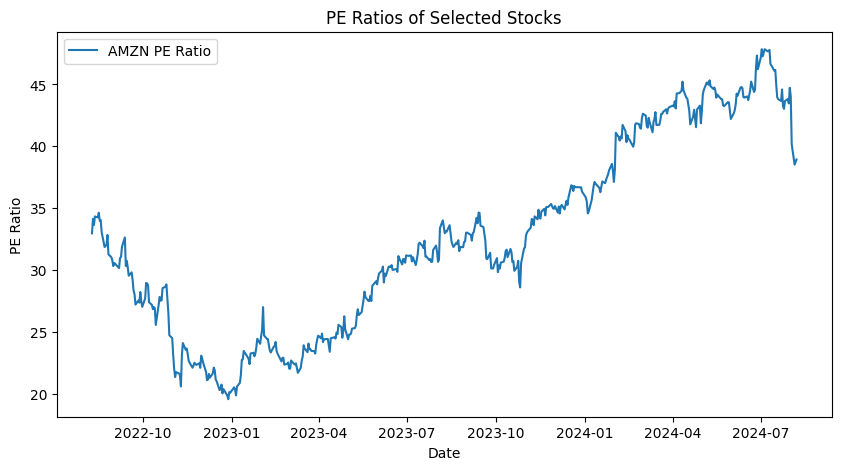

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


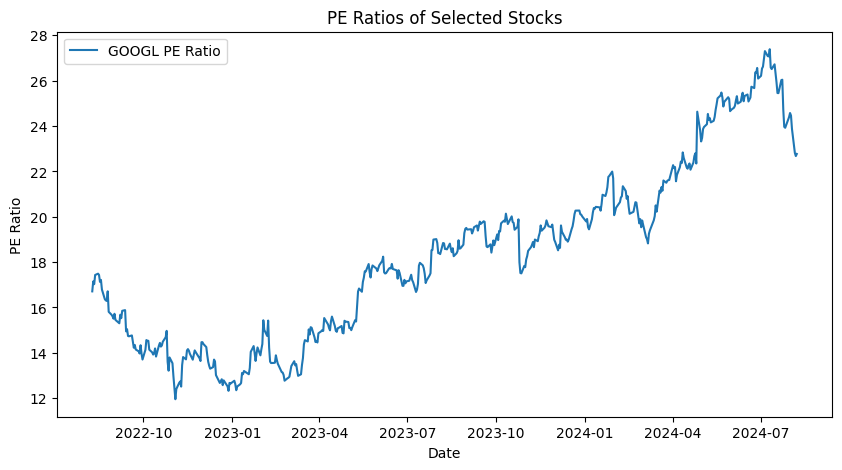

[*********************100%%**********************]  1 of 1 completed


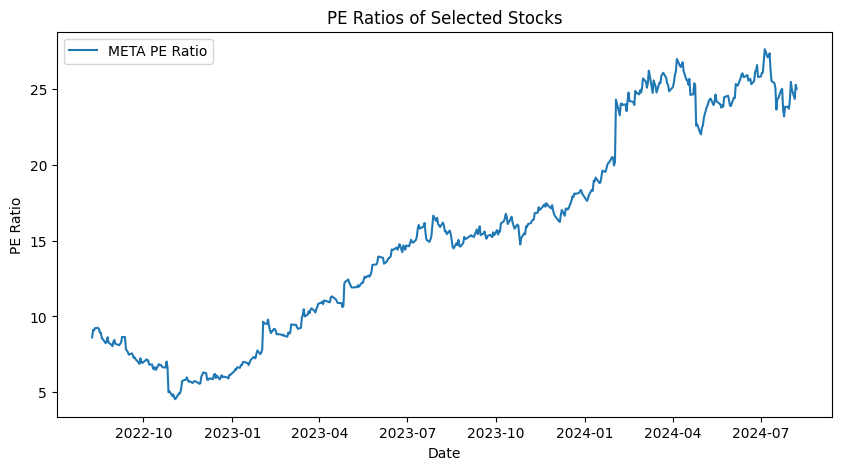

[*********************100%%**********************]  1 of 1 completed


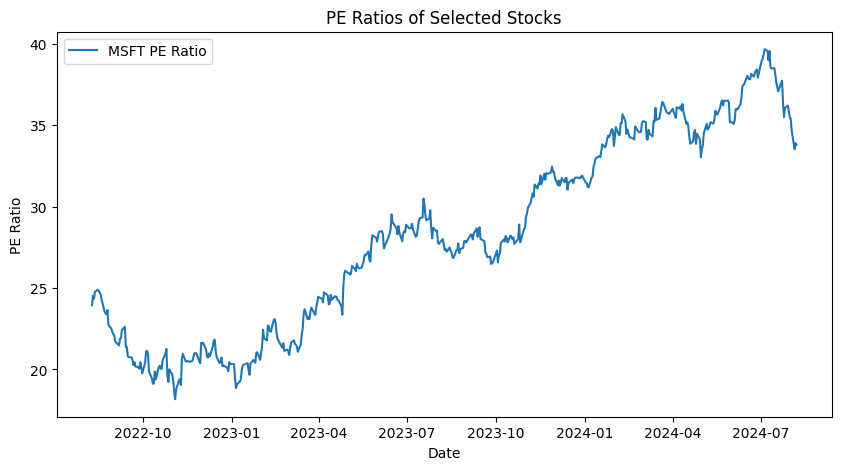

[*********************100%%**********************]  1 of 1 completed


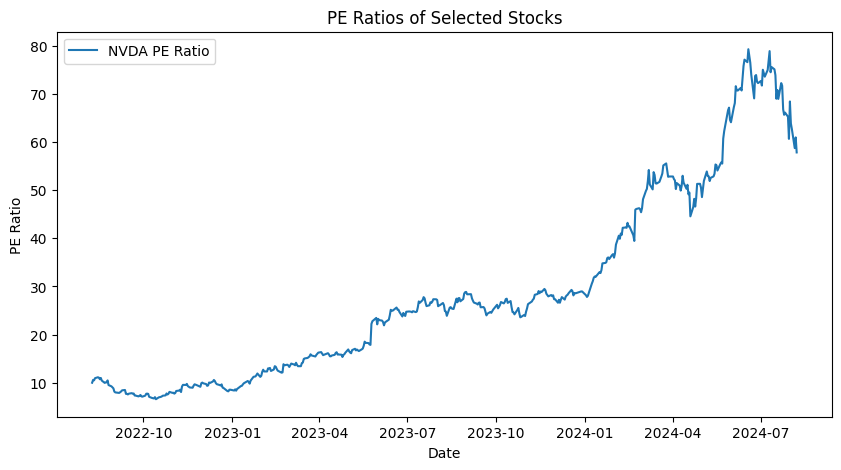

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


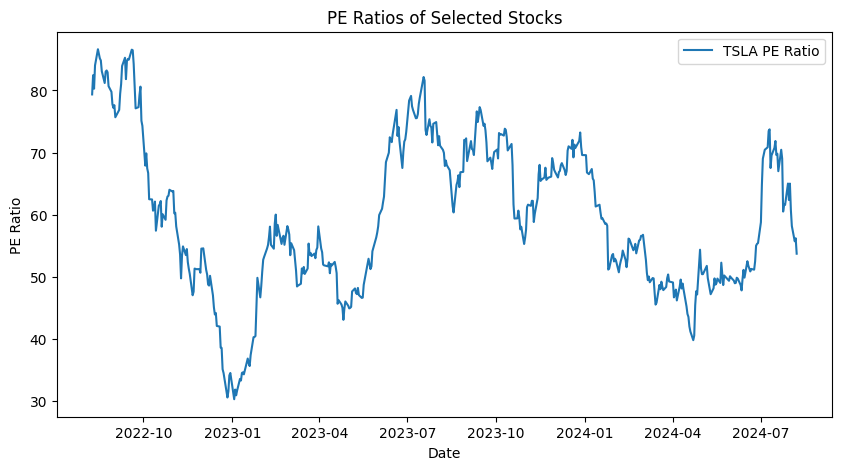

In [ ]:
# Download historical data for each ticker and plot its P/E ratios
for ticker in tickers:
    stock = yf.Ticker(ticker)
    eps = stock.info.get('trailingEps') # Retrieve the trailing EPS value from the stock's info
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_pe_ratios(data_ticker, ticker, eps)


### Beta

**What is Beta:** Beta measures a stock's volatility relative to the overall market. A beta greater than 1 indicates higher volatility than the market, while a beta less than 1 indicates lower volatility.

**How to Interpret:** High beta values (>1) indicate that the stock is more volatile than the market, meaning it may offer higher returns but also higher risks. Low beta values (<1) indicate less volatility and potentially more stable returns.

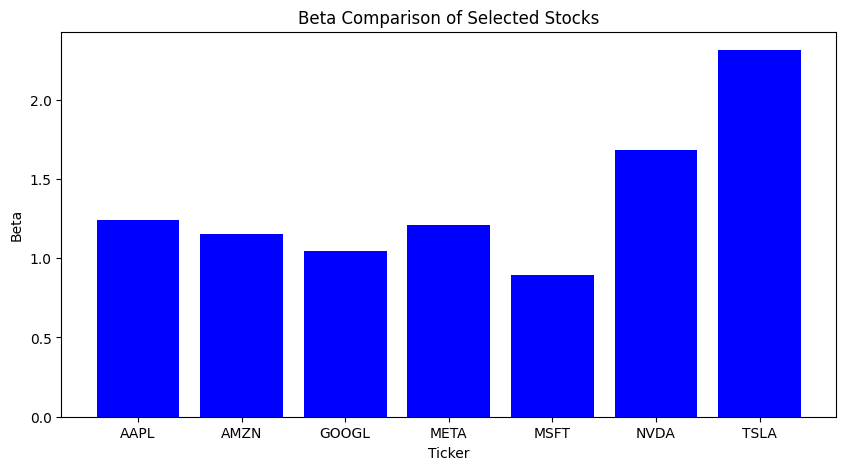

In [ ]:
# Plot beta comparison for a list of tickers over a specified date range
plot_beta_comparison(tickers, start_date,end_date)

### Moving Average Convergence Divergence (MACD)



**What is MACD:** The Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price.

**How to Interpret:** The MACD line crossing above the signal line indicates a bullish signal, suggesting that it may be time to buy. Conversely, the MACD line crossing below the signal line indicates a bearish signal, suggesting that it may be time to sell.

[*********************100%%**********************]  1 of 1 completed


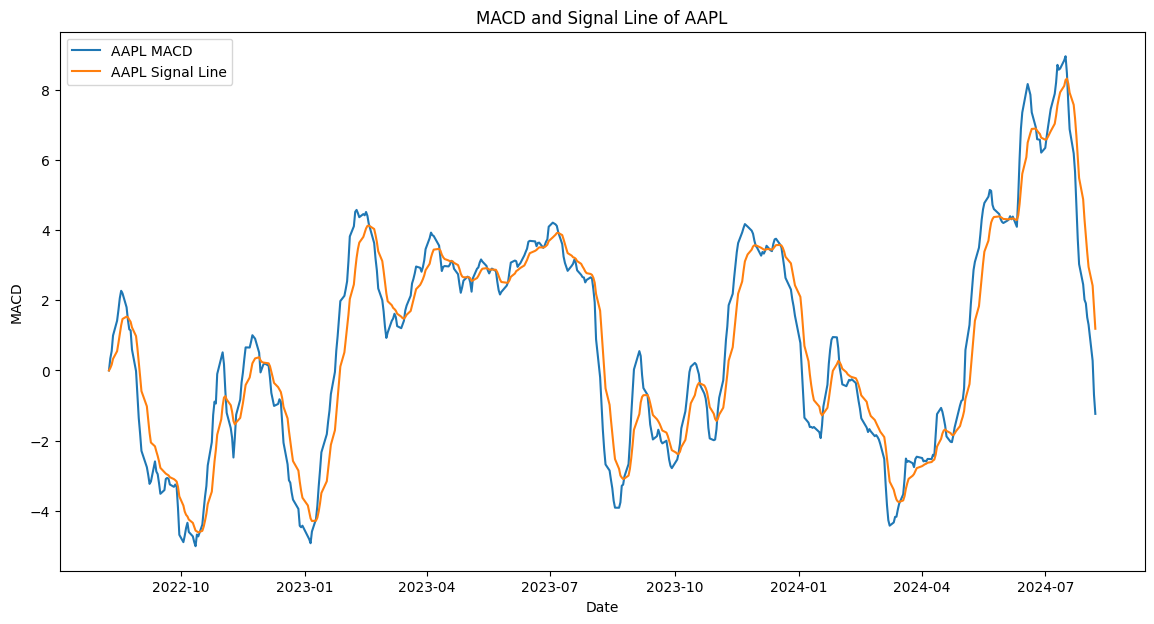

[*********************100%%**********************]  1 of 1 completed


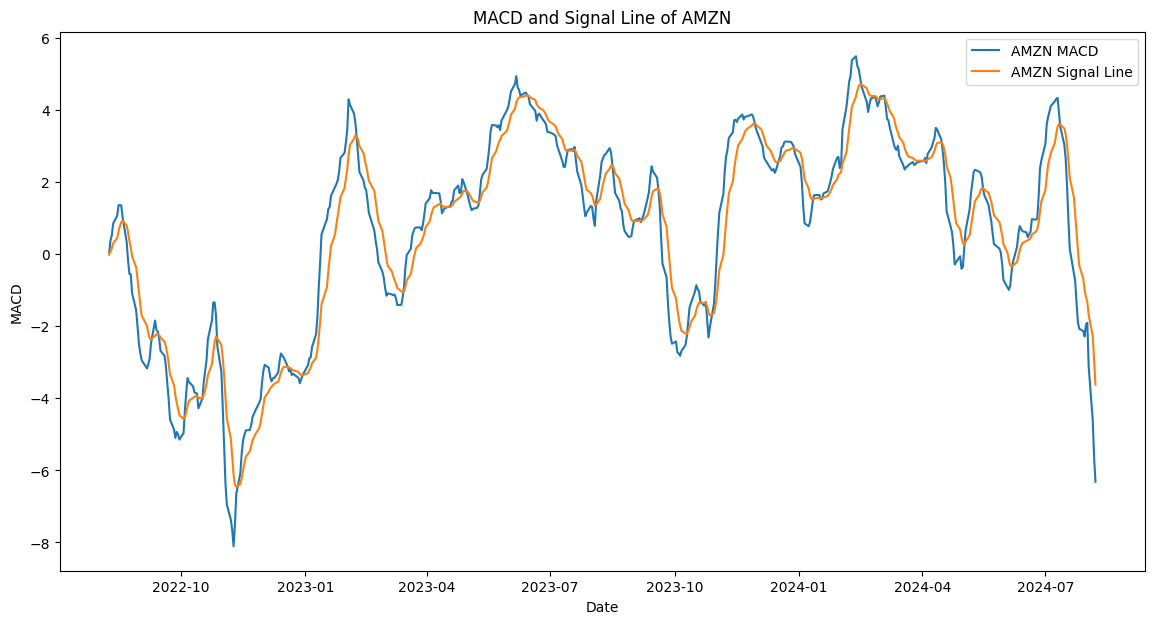

[*********************100%%**********************]  1 of 1 completed


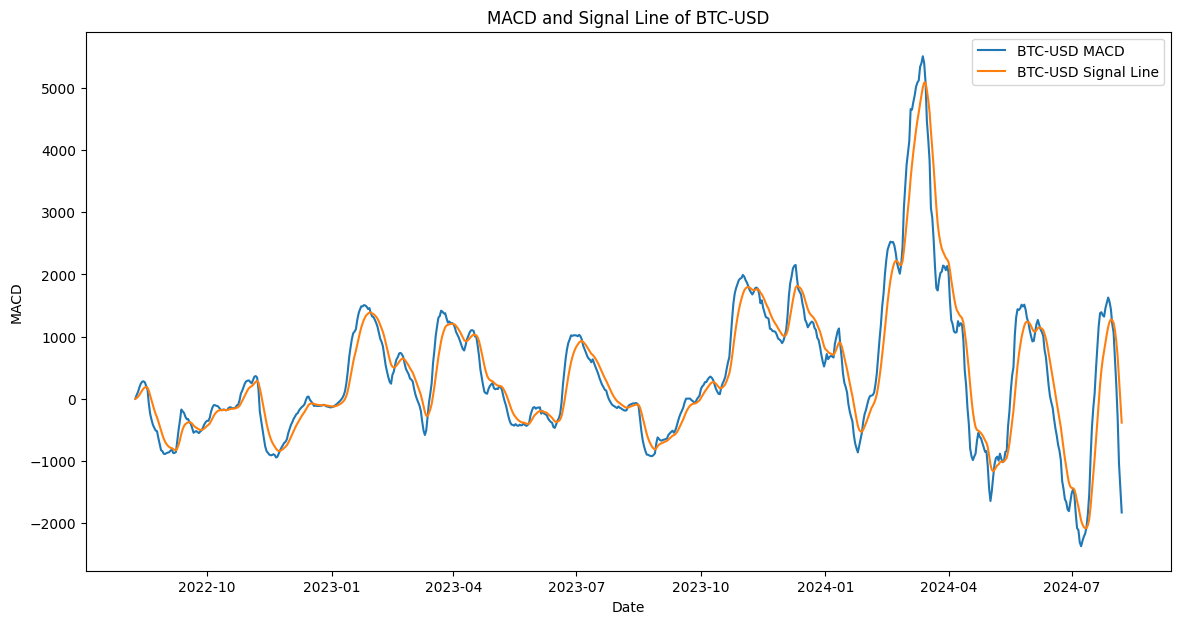

[*********************100%%**********************]  1 of 1 completed


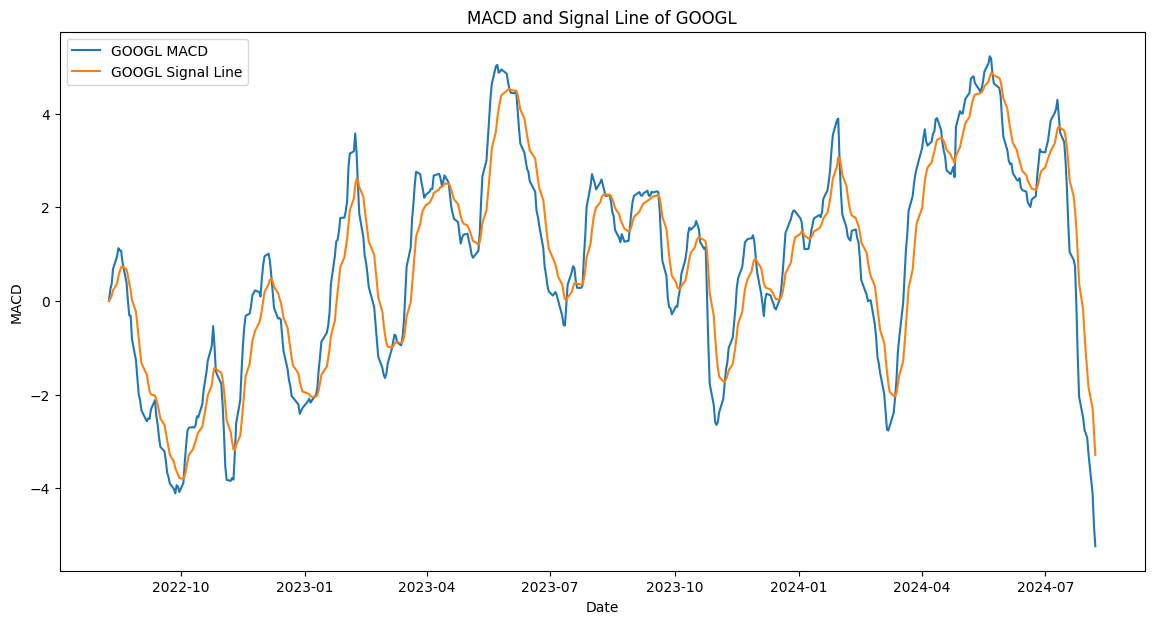

[*********************100%%**********************]  1 of 1 completed


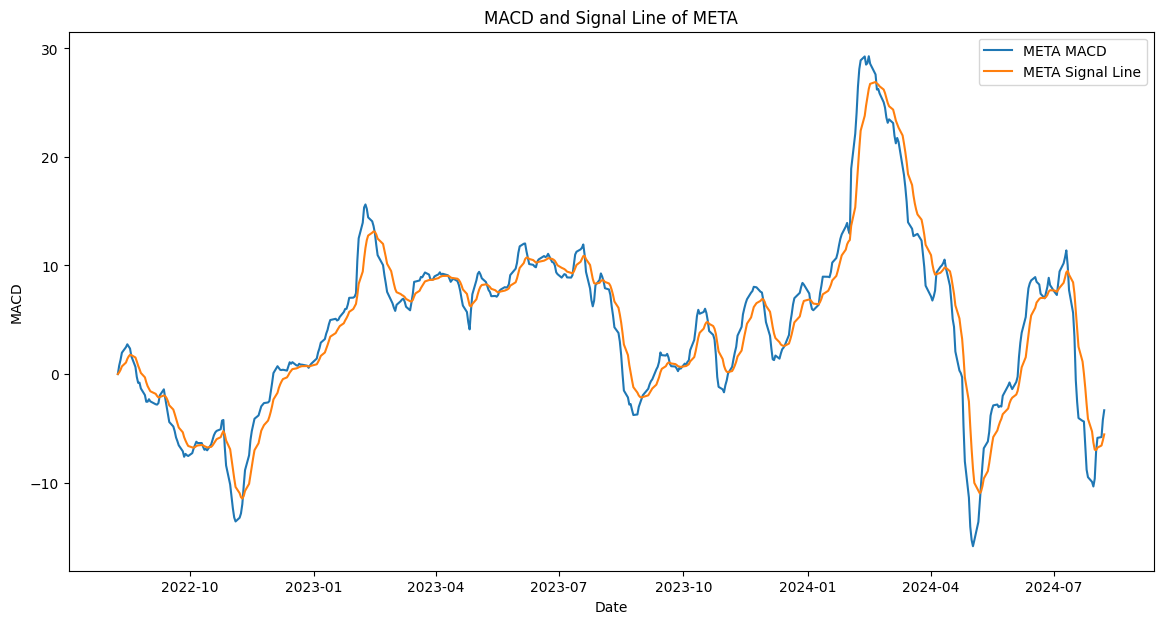

[*********************100%%**********************]  1 of 1 completed


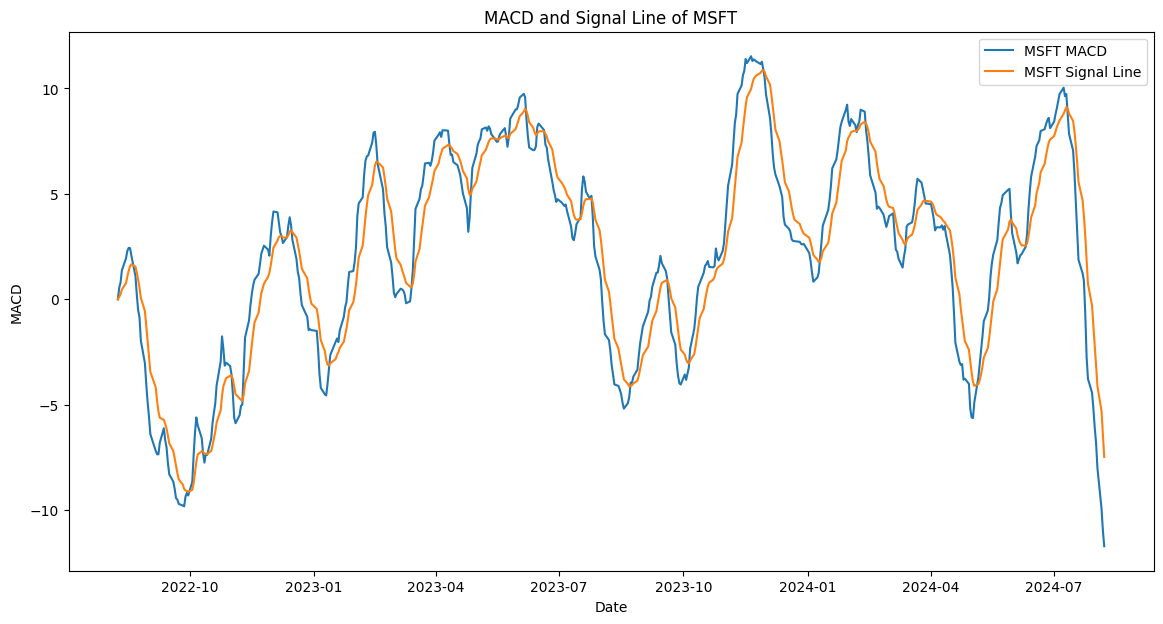

[*********************100%%**********************]  1 of 1 completed


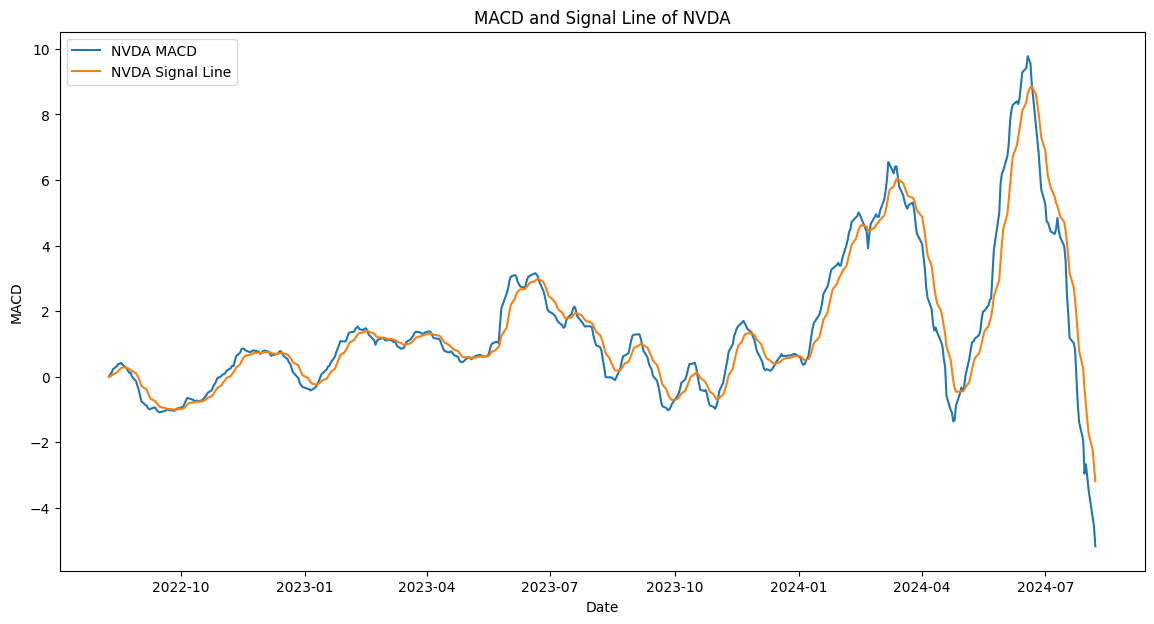

[*********************100%%**********************]  1 of 1 completed


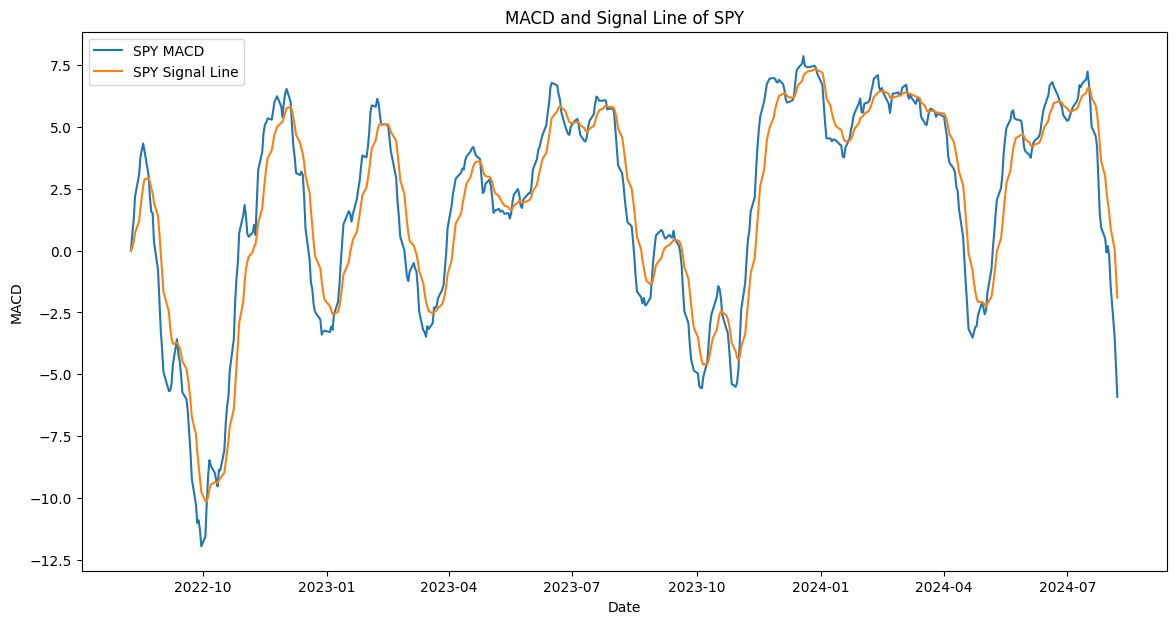

[*********************100%%**********************]  1 of 1 completed


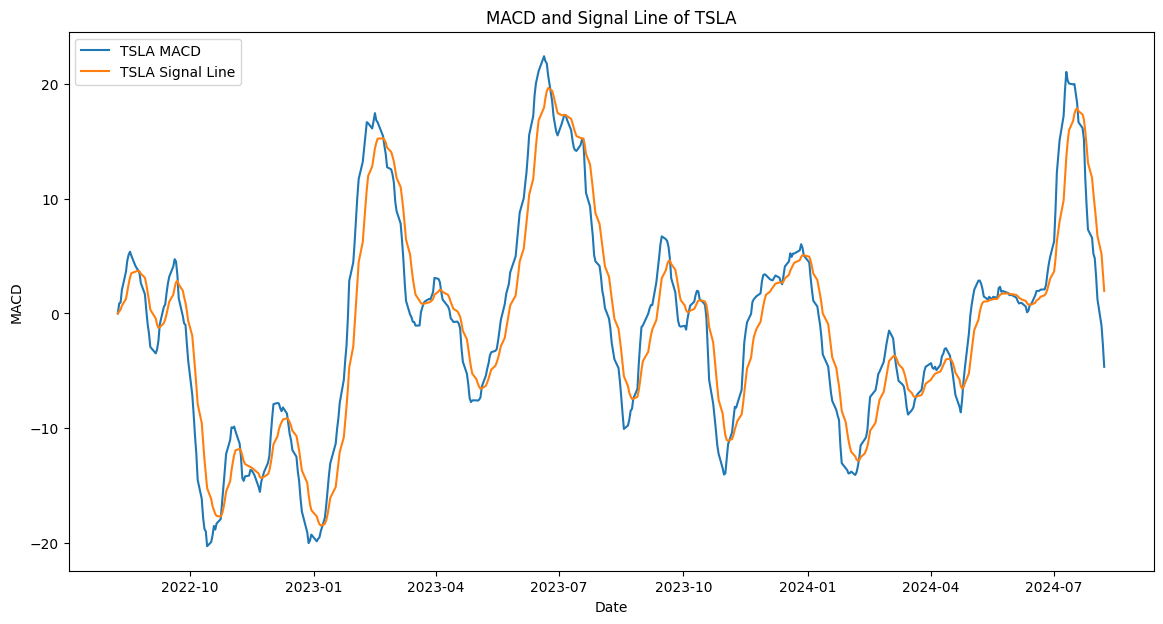

In [ ]:
# Download historical data for each ticker and plot its MACD
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_macd(data_ticker, ticker)


### KPIs

In [ ]:
# Calculate KPIs for the defined tickers and date range
kpi_data = calculate_kpis(tickers, start_date, end_date)

# Create a prompt to generate an executive summary with recommendations based on KPI data
prompt = f""" Read this data {kpi_data} and provide an executive summary with recommendations"""

# Get the response from the LLM based on the provided prompt
get_llm_response(llm = llm, prompt = prompt)

### Executive Summary

#### Overview
This report provides an analysis of key financial metrics and technical indicators for a selection of major stocks and assets, including AAPL, AMZN, BTC-USD, GOOGL, META, MSFT, NVDA, SPY, and TSLA. The analysis covers the Relative Strength Index (RSI), Bollinger Bands, Price-to-Earnings (P/E) Ratio, Beta, and Moving Average Convergence Divergence (MACD) for each asset. The data spans from August 2022 to August 2024.

#### Key Findings

1. **AAPL (Apple Inc.)**
   - **RSI**: Currently at 28.93, indicating the stock is approaching oversold territory.
   - **Bollinger Bands**: The stock is near the lower band, suggesting it may be undervalued.
   - **P/E Ratio**: 31.94, relatively high but not extreme.
   - **Beta**: 1.244, indicating higher volatility compared to the market.
   - **MACD**: Negative, suggesting a bearish trend.

2. **AMZN (Amazon.com Inc.)**
   - **RSI**: 28.78, indicating the stock is oversold.
   - **Bollinger Bands**: Near the lower band, suggesting potential undervaluation.
   - **P/E Ratio**: 38.94, high but typical for growth stocks.
   - **Beta**: 1.155, indicating moderate volatility.
   - **MACD**: Negative, indicating a bearish trend.

3. **BTC-USD (Bitcoin)**
   - **RSI**: 26.35, indicating oversold conditions.
   - **Bollinger Bands**: Near the lower band, suggesting potential undervaluation.
   - **P/E Ratio**: Not applicable.
   - **Beta**: Not applicable.
   - **MACD**: Strongly negative, indicating a bearish trend.

4. **GOOGL (Alphabet Inc.)**
   - **RSI**: 24.93, indicating the stock is oversold.
   - **Bollinger Bands**: Near the lower band, suggesting potential undervaluation.
   - **P/E Ratio**: 22.77, reasonable for a tech giant.
   - **Beta**: 1.046, indicating moderate volatility.
   - **MACD**: Negative, indicating a bearish trend.

5. **META (Meta Platforms Inc.)**
   - **RSI**: 54.57, indicating neutral conditions.
   - **Bollinger Bands**: Near the middle band, suggesting fair valuation.
   - **P/E Ratio**: 24.99, reasonable for a tech company.
   - **Beta**: 1.212, indicating higher volatility.
   - **MACD**: Negative, but improving.

6. **MSFT (Microsoft Corp.)**
   - **RSI**: 24.73, indicating the stock is oversold.
   - **Bollinger Bands**: Near the lower band, suggesting potential undervaluation.
   - **P/E Ratio**: 33.79, high but typical for a tech leader.
   - **Beta**: 0.894, indicating lower volatility.
   - **MACD**: Negative, indicating a bearish trend.

7. **NVDA (NVIDIA Corp.)**
   - **RSI**: 33.96, indicating the stock is approaching oversold territory.
   - **Bollinger Bands**: Near the lower band, suggesting potential undervaluation.
   - **P/E Ratio**: 57.84, very high, indicating high growth expectations.
   - **Beta**: 1.68, indicating high volatility.
   - **MACD**: Negative, indicating a bearish trend.

8. **SPY (S&P 500 ETF)**
   - **RSI**: 30.04, indicating the ETF is oversold.
   - **Bollinger Bands**: Near the lower band, suggesting potential undervaluation.
   - **P/E Ratio**: Not applicable.
   - **Beta**: Not applicable.
   - **MACD**: Negative, indicating a bearish trend.

9. **TSLA (Tesla Inc.)**
   - **RSI**: 29.12, indicating the stock is oversold.
   - **Bollinger Bands**: Near the lower band, suggesting potential undervaluation.
   - **P/E Ratio**: 53.71, high but typical for a high-growth company.
   - **Beta**: 2.313, indicating very high volatility.
   - **MACD**: Negative, indicating a bearish trend.

#### Recommendations

1. **AAPL, AMZN, GOOGL, MSFT, NVDA, TSLA**: These stocks are currently oversold and near their lower Bollinger Bands, suggesting potential buying opportunities. However, the negative MACD indicates bearish trends, so it may be prudent to wait for a confirmation of trend reversal before making significant investments.

2. **BTC-USD**: Bitcoin is also oversold and near its lower Bollinger Band, indicating a potential buying opportunity. However, the strongly negative MACD suggests caution.

3. **META**: Meta Platforms is in a neutral RSI range and near its middle Bollinger Band, indicating fair valuation. The improving MACD suggests it may be a good time to consider buying.

4. **SPY**: The S&P 500 ETF is oversold and near its lower Bollinger Band, suggesting a potential buying opportunity. However, the negative MACD indicates a bearish trend, so caution is advised.

5. **General Advice**: Given the overall bearish trends indicated by the MACD for most assets, it may be wise to adopt a cautious approach. Consider waiting for more definitive signs of trend reversals or diversifying investments to mitigate risk.

#### Conclusion
The current market conditions suggest that many major stocks and assets are oversold and potentially undervalued. However, the prevailing bearish trends indicated by the MACD warrant a cautious approach. Investors should consider waiting for confirmation of trend reversals or diversifying their portfolios to manage risk effectively.

### MPT

In [ ]:
# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio performance metrics.

    Parameters:
    weights (array): Asset weights in the portfolio.
    mean_returns (Series): Mean returns for each asset.
    cov_matrix (DataFrame): Covariance matrix of asset returns.

    Returns:
    float: Portfolio returns.
    float: Portfolio standard deviation.
    """
    # Calculate the expected portfolio return
    returns = np.sum(mean_returns * weights)

    # Calculate the portfolio standard deviation (volatility)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

# Function to calculate the negative Sharpe ratio
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """
    Calculate the negative Sharpe ratio for a given portfolio.

    Parameters:
    weights (array): Asset weights in the portfolio.
    mean_returns (Series): Mean returns for each asset.
    cov_matrix (DataFrame): Covariance matrix of asset returns.
    risk_free_rate (float): Risk-free rate.

    Returns:
    float: Negative Sharpe ratio.
    """
    # Calculate the negative Sharpe ratio of the portfolio
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    # Return the negative Sharpe ratio (to minimize in optimization problems)
    return -(p_returns - risk_free_rate) / p_std

# Function to find the portfolio with the maximum Sharpe ratio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    """
    Find the portfolio with the maximum Sharpe ratio.

    Parameters:
    mean_returns (Series): Mean returns for each asset.
    cov_matrix (DataFrame): Covariance matrix of asset returns.
    risk_free_rate (float): Risk-free rate.

    Returns:
    OptimizeResult: The optimization result containing the portfolio weights.
    """
    # Number of assets in the portfolio
    num_assets = len(mean_returns)

    # Define the arguments for the optimization function
    args = (mean_returns, cov_matrix, risk_free_rate)

    # Set up constraints (weights must sum to 1)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Define bounds for each asset weight (between 0 and 1)
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Perform optimization to maximize the Sharpe ratio (minimize the negative Sharpe ratio)
    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result


# Fetch the adjusted close prices for the tickers
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.04

# Optimize the portfolio for maximum Sharpe ratio
optimal_portfolio = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimal_portfolio.x

# Store the optimal weights in a dictionary and print the result
weights_dict = {tickers[i]: round(optimal_weights[i], 2) for i in range(len(tickers))}
print(weights_dict)


[*********************100%%**********************]  9 of 9 completed
<ipython-input-28-b7ea65af9e1d>:76: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


{'AAPL': 0.0, 'AMZN': 0.0, 'BTC-USD': 0.0, 'GOOGL': 0.0, 'META': 0.0, 'MSFT': 0.0, 'NVDA': 1.0, 'SPY': 0.0, 'TSLA': 0.0}


Explanation: Modern Portfolio Theory (MPT) aims to optimize the portfolio's return for a given level of risk. The Sharpe ratio is used to measure the performance of the portfolio compared to a risk-free asset, after adjusting for its risk. The portfolio with the highest Sharpe ratio is considered optimal.


### Black Litterman Model

In [ ]:
# Define risk-free rate
risk_free_rate = 0.001

# Fetch historical stock data
df = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate the sample mean returns and the covariance matrix
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

## Define market capitalizations
mcap = {}
# Iterate over each ticker symbol to retrieve market capitalization
for ticker in tickers:
  stock = yf.Ticker(ticker)
  try:
    # Attempt to get the market capitalization from stock info
    mcap[ticker] = stock.info['marketCap']
  except KeyError:
    # If the market capitalization is not available, set it to None
    mcap[ticker] = None

# Manually set the market capitalization for the S&P 500 index (SPY)
mcap['SPY'] = 45000000000000

# Define beliefs (Microsoft will outperform Google by 5%)
Q = np.array([0.05])                # Define the vector of expected returns differences (our belief)
P = np.zeros((1, len(tickers)))     # Initialize the matrix of constraints
P[0, tickers.index('MSFT')] = 1     # Set the coefficient for Microsoft to 1
P[0, tickers.index('GOOGL')] = -1   # Set the coefficient for Google to -1

# Calculate the market implied returns
market_prices = df["SPY"]
delta = black_litterman.market_implied_risk_aversion(market_prices)
market_prior = black_litterman.market_implied_prior_returns(mcap, delta, S, risk_free_rate)

# Create the Black-Litterman model
bl = BlackLittermanModel(S,                                   # Covariance matrix of asset returns
                         Q  = Q,                              # Vector of expected returns differences (our beliefs)
                         P = P,                               # Matrix representing the assets involved in the beliefs
                         pi = market_prior,                   # Equilibrium market returns
                         market_weights = market_prior,       # Market capitalization weights (used for the equilibrium returns)
                         risk_free_rate = risk_free_rate)     # Risk-free rate for the model

# Get the adjusted returns and covariance matrix
bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()

# Optimize the portfolio for maximum Sharpe ratio
ef = EfficientFrontier(bl_returns, bl_cov)              # Create an Efficient Frontier object with the adjusted returns and covariance matrix
weights = ef.max_sharpe(risk_free_rate=risk_free_rate)  # Calculate the optimal portfolio weights that maximize the Sharpe ratio, considering the risk-free rate
cleaned_weights = ef.clean_weights()                    # Clean up the weights to remove very small values for better interpretability

# Print the optimal weights and portfolio performance
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


[*********************100%%**********************]  9 of 9 completed
/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")


OrderedDict([('AAPL', 0.02948), ('AMZN', 0.0), ('BTC-USD', 0.01978), ('GOOGL', 0.0), ('META', 0.00827), ('MSFT', 0.17654), ('NVDA', 0.04144), ('SPY', 0.71096), ('TSLA', 0.01352)])
Expected annual return: 10.5%
Annual volatility: 15.4%
Sharpe Ratio: 0.67


/usr/local/lib/python3.10/dist-packages/pypfopt/black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.10473151065700981, 0.154422192371005, 0.6717396577804765)

**Explanation:**

 The Black-Litterman Model combines the CAPM equilibrium market returns with subjective views to create a more stable and intuitive expected return vector. It helps in adjusting the market equilibrium returns based on the investor's views and confidence levels, resulting in a more personalized and optimized portfolio.